<a href="https://colab.research.google.com/github/yiyichanmyae/time_series/blob/main/5_RNN_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using a Simple RNN for forecasting

using recurrent neural networks (RNNs) to build a forecasting model.

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions



In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
  """
    Visualizes time series data
  """
  plt.figure(figsize=(10,6))

  if type(series) is tuple:
    for series_num in series:
      plt.plot(time[start:end], series[start:end], format)
  else:
    plt.plot(time[start:end], series[start:end], format)

  plt.xlabel("time")
  plt.ylabel("value")
  plt.grid(True)
  plt.show()

def trend(time, slope=0):
  return time*slope

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4,
                  np.cos(season_time *2 *np.pi),
                  1/np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeats the same pattern at each period

  Args:
    time (array of int) - contains the time steps
    period (int) - number of time steps before the pattern repeats
    amplitude (int) - peak measured value in a period
    phase (int) - number of time steps to shift the measured values

  Returns:
    data_pattern (array of float) - seasonal data scaled by the defined amplitude
  """

  # define the measured values per period
  season_time = ((time + phase)%period)/ period

  # generate the seasonal data scaled by the defined amplitude
  data_pattern = amplitude + seasonal_pattern(season_time)
  return data_pattern

def noise(time, noise_level=1, seed=None):
  """ generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
  """
  rnd = np.random.RandomState(seed)
  noise = rnd.randn(len(time)) * noise_level
  return noise

## Generate the synthetic data

time : [0.000e+00 1.000e+00 2.000e+00 ... 1.456e+03 1.457e+03 1.458e+03]


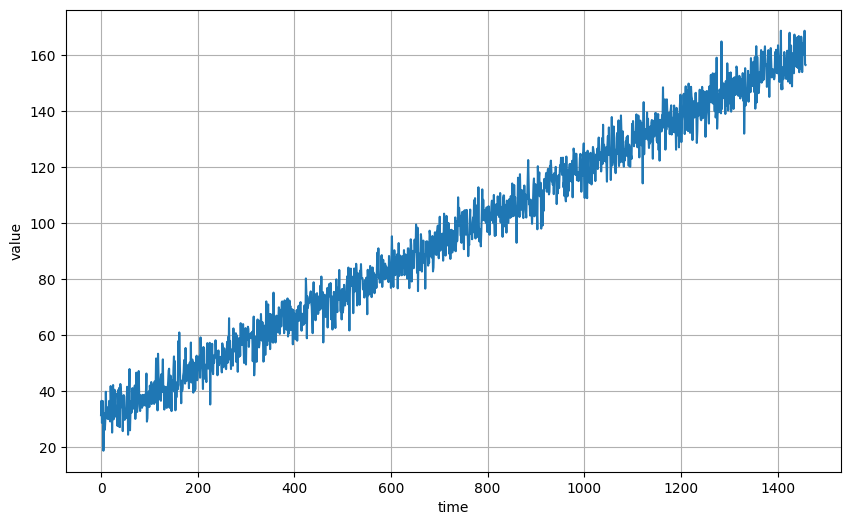

In [18]:
time = np.arange(4 * 365 - 1, dtype="float32")
print(f"time : {time}")
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5


series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=1773)

plot_series(time, series)

## Split the dataset

In [19]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [20]:
# parameters
window_size= 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


## Build the model

Your model is composed mainly of SimpleRNN layers. As mentioned in the lectures, this type of RNN simply routs its output back to the input. You will stack two of these layers in your model so the first one should have return_sequences set to True.

As mentioned in the documentation, SimpleRNN layers expect a 3-dimensional tensor input with the shape [batch, timesteps, feature]. With that, you need to reshape your window from (32, 20) to (32, 20, 1). This means the 20 datapoints in the window will be mapped to 20 timesteps of the RNN. You can do this reshaping in a separate cell but you can also do this within the model itself by using Lambda layers. Notice the first layer below. It defines a lambda function that adds a dimension at the last axis of the input. That's exactly the transformation you need. For the input_shape, you can specify None (like in the lecture video) if you want the model to be more flexible with the number of timesteps. Alternatively, you can set it to window_size as shown below if you want to set the timesteps dimension to the expected size of your data windows.

Normally, you can just a have a Dense layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the activation functions you used in your model. SimpleRNN uses tanh by default and that has an output range of [-1,1]. You will use another Lambda() layer to scale the output by 100 before it adjusts the layer weights. Feel free to remove this layer later after this lab and see what results you get.


In [21]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In [22]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 12ms/step - loss: 243.5785 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 238.8184 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 14ms/step - loss: 228.8271 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 209.5587 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 196.5484 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 17ms/step - loss: 188.7072 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 181.8150 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 23ms/step - loss: 174.9503 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 22ms/step - loss: 167.8125 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 18ms/step - loss: 160.2929 - lr: 2.8184e-08

(1e-08, 0.001, 0.0, 50.0)

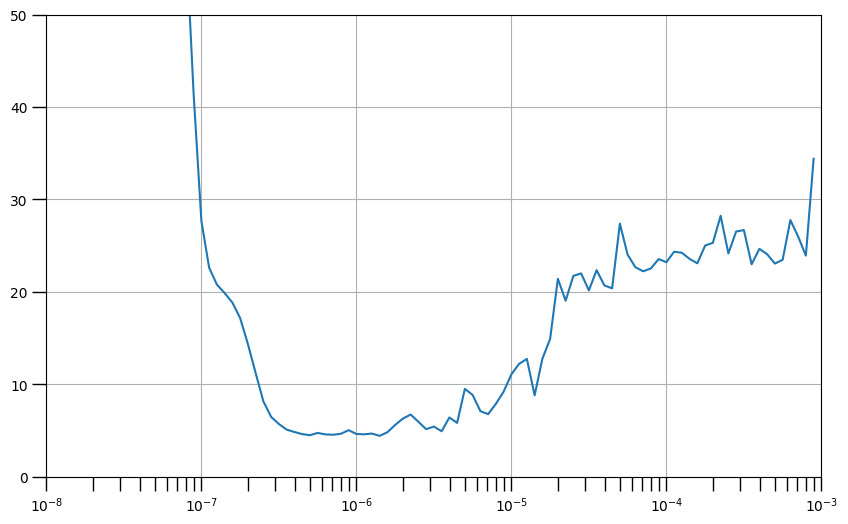

In [23]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

(1e-07, 0.0001, 0.0, 20.0)

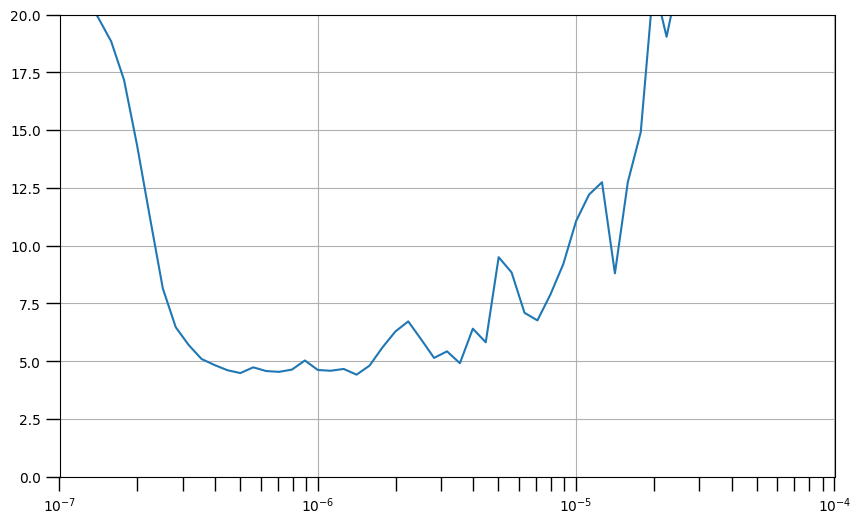

In [24]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

In [25]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 93.8221 - mae: 94.3217
Epoch 2/100
31/31 [==============================] - 0s 11ms/step - loss: 23.5677 - mae: 24.0644
Epoch 3/100
31/31 [==============================] - 0s 11ms/step - loss: 21.0361 - mae: 21.5325
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 19.7125 - mae: 20.2095
Epoch 5/100
31/31 [==============================] - 0s 11ms/step - loss: 18.0587 - mae: 18.5542
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 14.9838 - mae: 15.4758
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 10.4865 - mae: 10.9791
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 7.4191 - mae: 7.9027
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 6.0303 - mae: 6.5119
Epoch 10/100
31/31 [==============================] - 1s 12ms/step - loss: 6.0806 - mae: 6.5681
Epoch 11/100
31/31 [===============

## Model Prediction

1/1 [==============================] - 0s 23ms/step


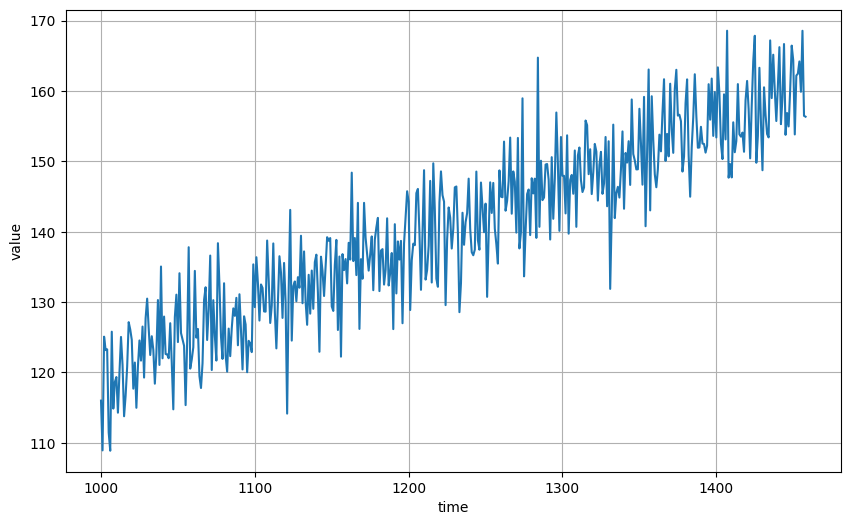

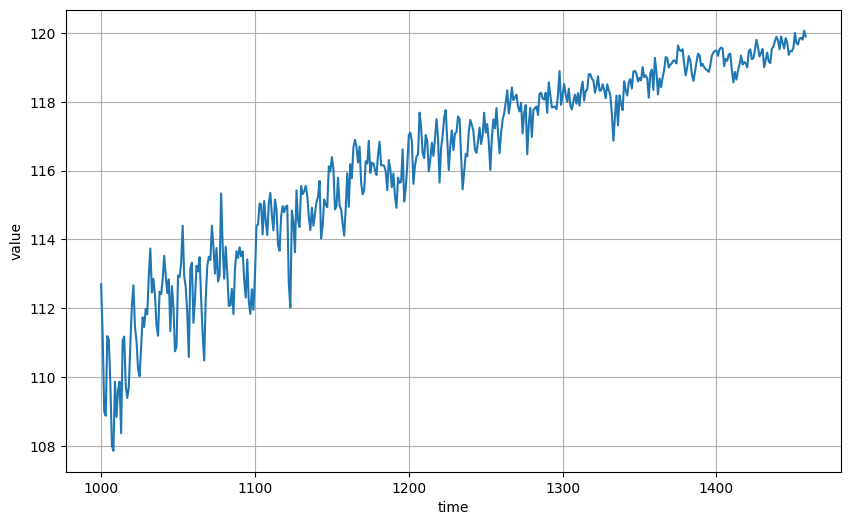

In [27]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid,x_valid)
plot_series(time_valid,results)


15/15 [==============================] - 0s 15ms/step


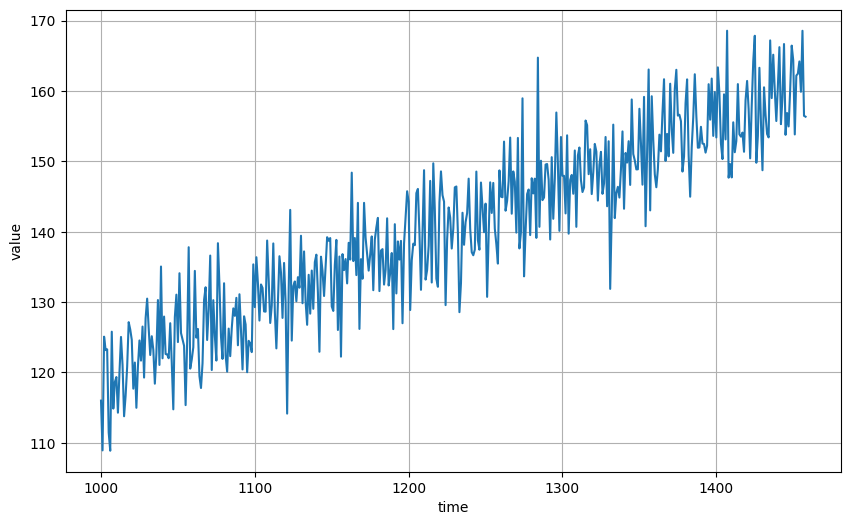

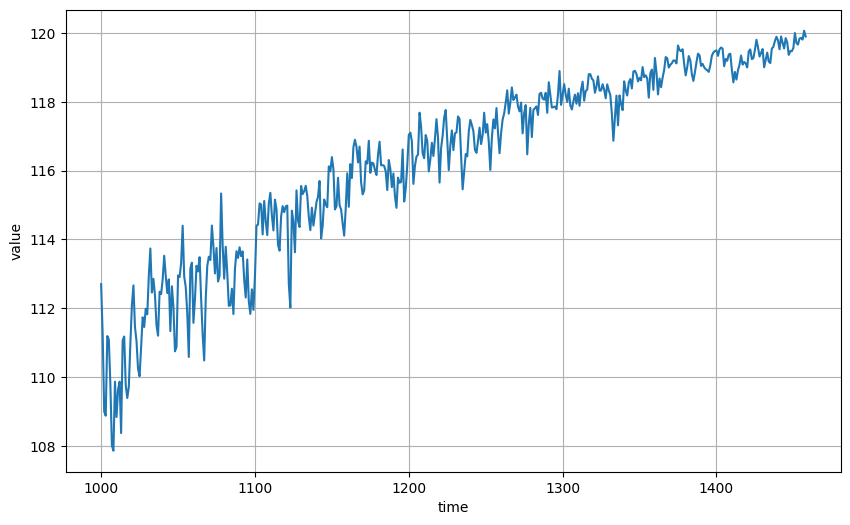

In [30]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
# plot_series(time_valid, (x_valid, results))
plot_series(time_valid,x_valid)
plot_series(time_valid,results)

In [31]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

704.0556
24.309374
